# Compositional Pattern Producing Networks in Visual

This guide will cover the CPPNImage class in visual. This is a simple implementation of a Compositional Pattern Producing Network (CPPN) based on the tensorflow version from the lucid tutorial [xy2rgb](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/differentiable-parameterizations/xy2rgb.ipynb).

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup. We recommend you enable a free GPU with

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

## Install Visual

First we install visual if needed. 

In [1]:
try:
    import visual
except:
    !pip install -q git+https://github.com/pytorchbearer/visual
    import visual
    
print(visual.__version__)

     |████████████████████████████████| 143kB 6.5MB/s 
0.2.0.dev


## Load the Inception Network

We first load a model, for more info about this step have a look at the [quickstart guide](https://colab.research.google.com/github/pytorchbearer/visual/blob/master/docs/_static/notebooks/quickstart.ipynb).

In [2]:
from visual.models import IntermediateLayerGetter
from visual import RedirectReLUs
from torchvision.models import resnet18

model = IntermediateLayerGetter(RedirectReLUs(resnet18(pretrained=True)))
print(model.layer_names)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 193MB/s]


['model', 'model_conv1', 'model_bn1', 'model_relu', 'model_relu_redirected_module', 'model_relu_old_module', 'model_maxpool', 'model_layer1', 'model_layer1_0', 'model_layer1_0_conv1', 'model_layer1_0_bn1', 'model_layer1_0_relu', 'model_layer1_0_conv2', 'model_layer1_0_bn2', 'model_layer1_1', 'model_layer1_1_conv1', 'model_layer1_1_bn1', 'model_layer1_1_relu', 'model_layer1_1_conv2', 'model_layer1_1_bn2', 'model_layer2', 'model_layer2_0', 'model_layer2_0_conv1', 'model_layer2_0_bn1', 'model_layer2_0_relu', 'model_layer2_0_conv2', 'model_layer2_0_bn2', 'model_layer2_0_downsample', 'model_layer2_0_downsample_0', 'model_layer2_0_downsample_1', 'model_layer2_1', 'model_layer2_1_conv1', 'model_layer2_1_bn1', 'model_layer2_1_relu', 'model_layer2_1_conv2', 'model_layer2_1_bn2', 'model_layer3', 'model_layer3_0', 'model_layer3_0_conv1', 'model_layer3_0_bn1', 'model_layer3_0_relu', 'model_layer3_0_conv2', 'model_layer3_0_bn2', 'model_layer3_0_downsample', 'model_layer3_0_downsample_0', 'model_lay

## A simple CPPNImage

Now that we have a model, we can define and generate a CPPNImage. A CPPN is a network which maps a grid of co-ordinates to an image. The CPPNImage in visual is a network of $1 \times 1$ convolutions which can be controlled by setting the number of layers, the number of filters per layer and the activation function. We include a few normalised activation functions following those defined in [xy2rgb](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/differentiable-parameterizations/xy2rgb.ipynb). First we'll generate an imgae using the defaults, then have a look at what happens when we change the activation function.

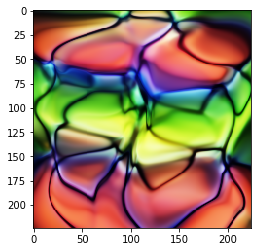

In [3]:
%matplotlib inline
from torch import optim

from visual import CPPNImage, Channel, BasicAscent
from visual import transforms

transform = transforms.Compose([
    transforms.SpatialJitter(2),
    transforms.RandomScale([1.1 ** (n / 10.) for n in range(-10, 11)]),
    transforms.RandomRotate(list(range(-5, 6)))
])

image = CPPNImage((3, 224, 224), transform=transform, correlate=True).sigmoid()

optimizer = optim.Adam(filter(lambda x: x.requires_grad, image.parameters()), lr=0.005)

criterion = Channel(15, 'model_layer4_0_conv1')
BasicAscent(image, criterion, optimizer=optimizer, steps=512).to_pyplot().run(model, device='cuda', verbose=0)

### Unbiased Activation


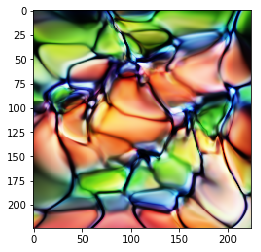

In [10]:
image = CPPNImage((3, 224, 224), transform=transform, correlate=True, activation=CPPNImage.UnbiasedComposite()).sigmoid()

optimizer = optim.Adam(filter(lambda x: x.requires_grad, image.parameters()), lr=0.005)

criterion = Channel(15, 'model_layer4_0_conv1')
BasicAscent(image, criterion, optimizer=optimizer, steps=512).to_file('out.png').to_pyplot().run(model, device='cuda', verbose=0)

### Normalised ReLU

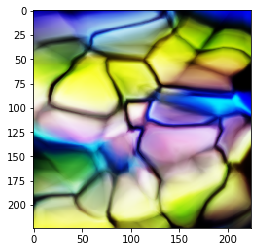

In [5]:
image = CPPNImage((3, 224, 224), transform=transform, correlate=True, activation=CPPNImage.NormalisedReLU()).sigmoid()

optimizer = optim.Adam(filter(lambda x: x.requires_grad, image.parameters()), lr=0.005)

criterion = Channel(15, 'model_layer4_0_conv1')
BasicAscent(image, criterion, optimizer=optimizer, steps=512).to_pyplot().run(model, device='cuda', verbose=0)

### Normalised Leaky ReLU

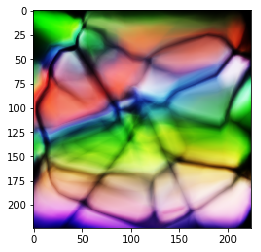

In [6]:
image = CPPNImage((3, 224, 224), transform=transform, correlate=True, activation=CPPNImage.NormalisedLeakyReLU()).sigmoid()

optimizer = optim.Adam(filter(lambda x: x.requires_grad, image.parameters()), lr=0.005)

criterion = Channel(15, 'model_layer4_0_conv1')
BasicAscent(image, criterion, optimizer=optimizer, steps=512).to_pyplot().run(model, device='cuda', verbose=0)

## Arbitrary Resolution

In this section we'll have a look at generating images at an arbitrary resolution using a trained CPPN. Specifically, we'll generate a hummingbird image like the one in the [torchbearer website](http://www.pytorchbearer.org/). Let's first create a hummingbird (class 94, find more [here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)) at the right aspect ratio but scaled down:

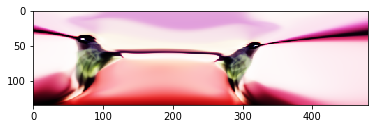

In [7]:
image = CPPNImage((3, int(1080 / 8.), int(1920 / 4.)), transform=transform, correlate=True).sigmoid()

optimizer = optim.Adam(filter(lambda x: x.requires_grad, image.parameters()), lr=0.005)

criterion = Channel(94, 'model')
BasicAscent(image, criterion, optimizer=optimizer, steps=512).to_pyplot().run(model, device='cuda', verbose=0)

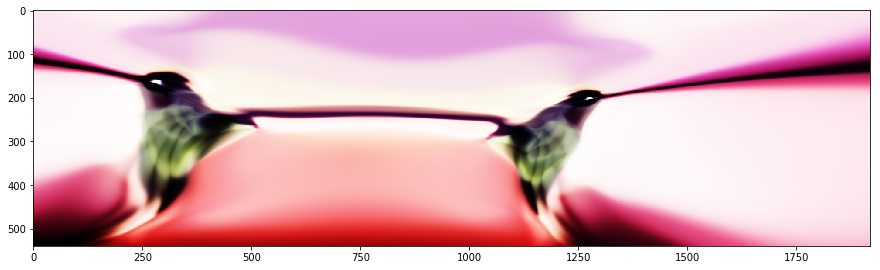

In [8]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15,15))
_ = image.resize(int(1080 / 2.), 1920).to_file('hummingbird.png').to_pyplot()